In [1]:
## Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## changing the current path to mounted Google Drive
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
## Verifying the present working directory
%pwd


'/content/drive/MyDrive'

In [4]:
## Cloning the github repository to present working directory on your Google Drive
!git  clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 14.21 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [5]:
## unzip archives  q - quite, n - don't overwrite
!unzip -q -n '/content/drive/My Drive/COVID-CT/Images-processed/CT_COVID.zip'
!unzip -q -n '/content/drive/My Drive/COVID-CT/Images-processed/CT_NonCOVID.zip'

# Importing the Required Libraries

In [6]:
import keras
import tensorflow as tf
import os,cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
keras.backend.image_data_format()
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization,InputLayer
from tensorflow.keras.optimizers import Adam,RMSprop,Adadelta,Adagrad,Adamax
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
print('Keras version is {}'.format(keras.__version__))
print ('Tensorflow verson is {}'.format(tf.__version__))
print ('OpenCv version is {}'.format(cv2.__version__))

Keras version is 2.6.0
Tensorflow verson is 2.6.0
OpenCv version is 4.1.2


In [7]:
## Renaming and counting image files with Covid and non-Covid Cases
path='/content/drive/My Drive/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/drive/MyDrive/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid Positive cases:  348
Covid Negative cases:  396


In [8]:
## Checking all the images where height or width of an image is less than 224 pixels
from PIL import Image
data_path = '/content/drive/MyDrive/'
#data_dir_list = os.listdir(data_path)
data_dir_list = ['CT_COVID','CT_NonCOVID']
odd_size_image = 0
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        filename = os.path.join(data_path + '/'+ dataset + '/'+ img)
        image_png = Image.open(filename)
        if (image_png.size[0] or image_png.size[1])<224 :
          #print (img, image_png.size)
          odd_size_image += 1
    print("number of odd sized images are {}\n".format(odd_size_image))

Loaded the images of dataset-CT_COVID

number of odd sized images are 57

Loaded the images of dataset-CT_NonCOVID

number of odd sized images are 77



In [9]:
## forcefully removing the Directory which is no longer required.
!rm -rf /content/drive/MyDrive/COVID-CT

In [10]:
## Resizing each image to 224x224 resizing , labeling
data_path = '/content/drive/My Drive/'
data_dir_list = ['CT_COVID','CT_NonCOVID']
img_rows=224
img_cols=224
num_channel=3
num_epoch=100
no_images=0
for dataset in data_dir_list:
    img_list = os.listdir(data_path + '/' + dataset)
    no_images = no_images+len(img_list)
print(no_images)
# Define the number of classes
labels = np.ones((no_images,),dtype='int64')
num_classes = 2
label_index=0
img_data_list=[]
img=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img)
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(224,224))
        input_img_resize = cv2.normalize(input_img_resize, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        img_data_list.append(input_img_resize)
        if dataset[0:4]==  'CT_C':
            labels[label_index] =  1 # labeling Covid images as 1
            #print(dataset[0])
        if dataset[0:4] == 'CT_N':
            labels[label_index] = 0   # labeling non Covid images as 0
        label_index = label_index+1

746
Loaded the images of dataset-CT_COVID

Loaded the images of dataset-CT_NonCOVID



In [11]:
img_data  = np.array(img_data_list) # coverting list of read images to array
print(img_data.shape)

(746, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


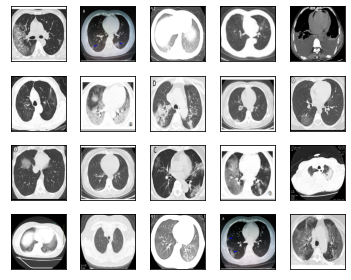

In [12]:
## Visualizing first 20 images from image array
plt.figure(figsize=(5, 4))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(img_data[i], cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [13]:
## to Make sure that format is (No of samples x height x width x dimension)
if num_channel==1:
    if K.image_data_format()=='th':
        img_data= np.expand_dims(img_data, axis=1)
        #print (img_data.shape)
    else:
        img_data= np.expand_dims(img_data, axis=3)
        #print (img_data.shape)

else:
    if K.image_data_format()=='th':
        img_data=np.rollaxis(img_data,3,1)
        #print (img_data.shape)
        labels[0:347] = 1 # assigning label to 1 Covid cases (348 images)
        labels[348:745] = 0 # assigning label to 0 Non-Covid cases ( 396 images)
                
labels[0:745]       

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
# Define the number of classes
num_classes = 2
names = ['COVID','NonCOVID']
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)
X,y = shuffle(img_data, Y, random_state=42) # shuffling the data 

In [22]:
## Splitting data 80% train and 20% test ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
print("X_train size is {} and y_train size is {}".format(X_train.shape,y_train.shape))
print("X_test size is {} and y_test size is {}".format(X_test.shape,y_test.shape))

X_train size is (596, 224, 224, 3) and y_train size is (596, 2)
X_test size is (150, 224, 224, 3) and y_test size is (150, 2)


## Feature Extraction using VGG16

In [30]:
# importing VGG16 and defining base model
from keras.applications import vgg16
vgg = vgg16.VGG16(include_top=True, weights='imagenet',input_shape=(224,224,3))
base_model = vgg
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
## Extract the last layer before predciton of  vgg16 model
last = base_model.layers[-2].output
pred = Dense(2, activation='softmax')(last)
model = Model(base_model.input, pred)
for layer in base_model.layers:
     layer.trainable = False


In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [33]:
## Compiling the model with Optimizer Adam (default parameters)
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])


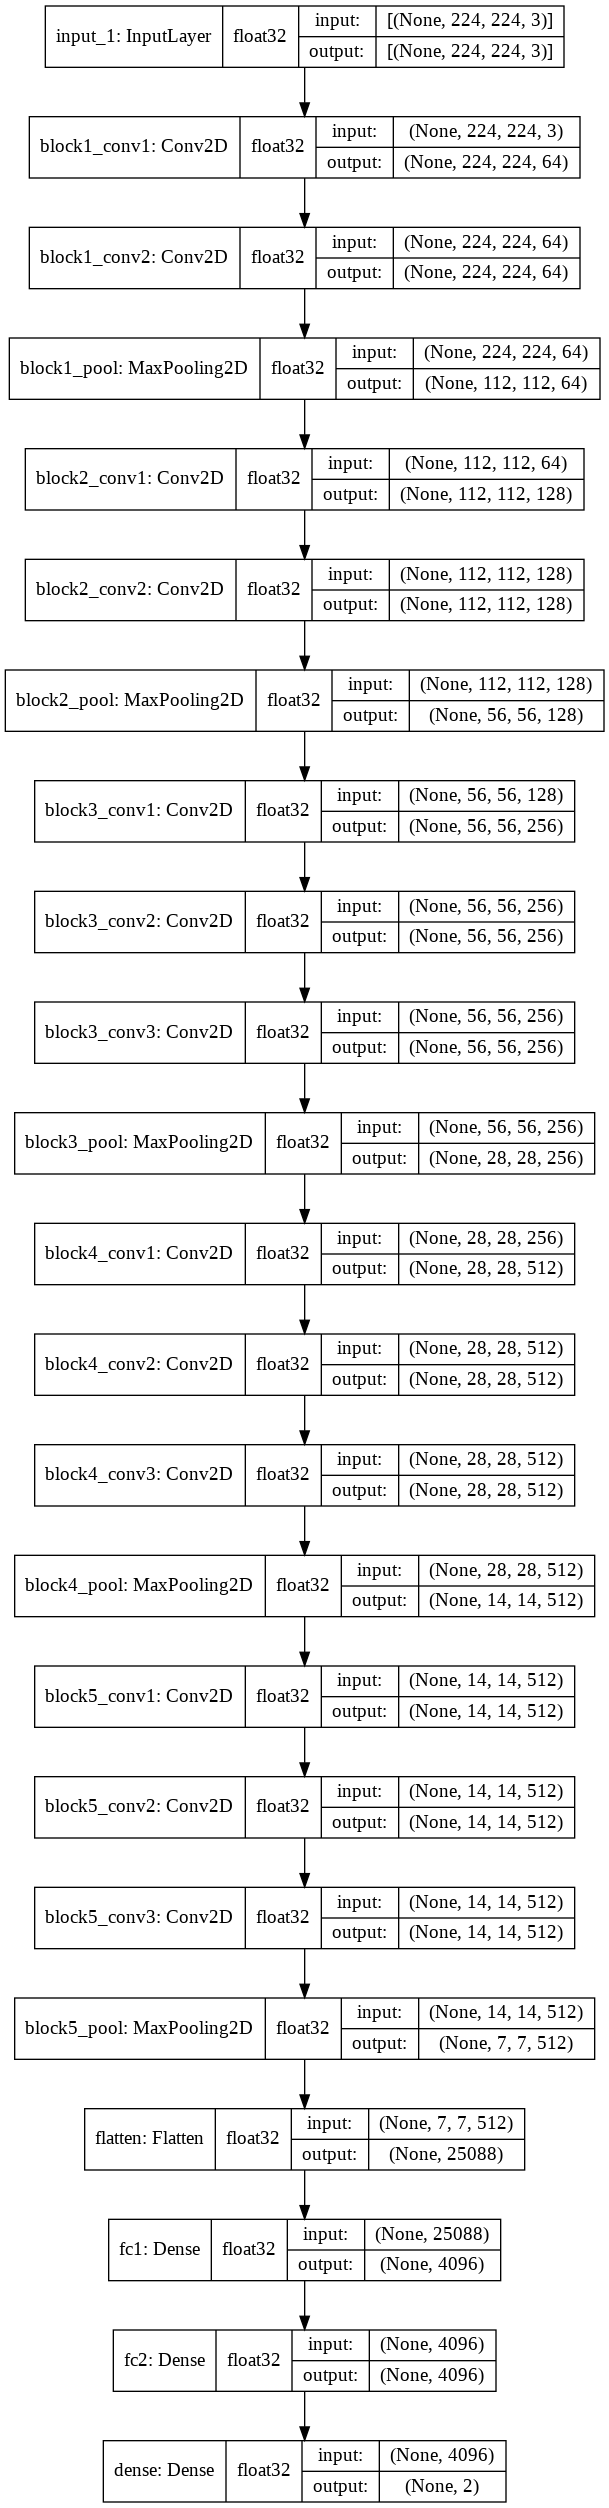

In [25]:
## Visualising the Model Summary
plot_model(model,show_dtype=True,show_layer_names=True,show_shapes=True,rankdir='TB')

In [26]:
## Creating custom call backs with patience =20 and saving the best weights of model training.
custom_callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model-fext.h5', save_best_only=True,verbose=1)
]

In [35]:
## removing history and previously created best weights file if you are training the model again.
#del history
!rm vgg16_model-fext.h5

In [36]:
## Model fit with validation split of 20% of the train data
history = model.fit(X_train,y_train,validation_split=0.2,epochs=100,batch_size=10,verbose=1,callbacks=custom_callbacks)

Epoch 1/100
48/48 [==============================] - 10s 190ms/step - loss: 0.7124 - accuracy: 0.5903 - val_loss: 0.6383 - val_accuracy: 0.6583

Epoch 00001: val_loss did not improve from 0.37361
Epoch 2/100
48/48 [==============================] - 8s 162ms/step - loss: 0.6094 - accuracy: 0.6597 - val_loss: 0.6234 - val_accuracy: 0.5917

Epoch 00002: val_loss did not improve from 0.37361
Epoch 3/100
48/48 [==============================] - 9s 184ms/step - loss: 0.6419 - accuracy: 0.6218 - val_loss: 0.6401 - val_accuracy: 0.5667

Epoch 00003: val_loss did not improve from 0.37361
Epoch 4/100
48/48 [==============================] - 9s 184ms/step - loss: 0.5705 - accuracy: 0.7038 - val_loss: 0.7216 - val_accuracy: 0.5667

Epoch 00004: val_loss did not improve from 0.37361
Epoch 5/100
48/48 [==============================] - 9s 185ms/step - loss: 0.5486 - accuracy: 0.7122 - val_loss: 0.6277 - val_accuracy: 0.6000

Epoch 00005: val_loss did not improve from 0.37361
Epoch 6/100
48/48 [=====

In [37]:
## Creating the DataFrame for trained model training history
history_df = pd.DataFrame.from_dict(history.history)
history_df['epoch'] = range(1,history_df.shape[0]+1)

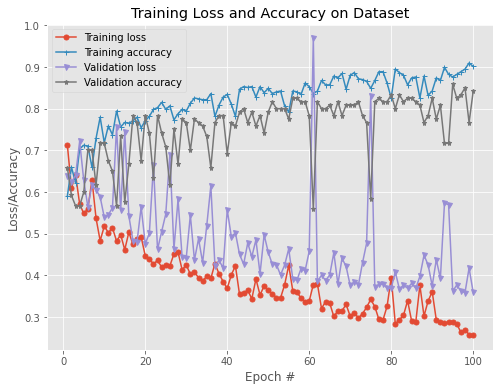

In [38]:
## Visualizing the Training Loss / Accuracy and Validation Loss/Accuracy
plt.style.use("ggplot")
fig,ax = plt.subplots()
ax.figure.set_size_inches([8,6])
ax.plot(history_df['epoch'],history_df['loss'],label='Training loss',marker='o',ms=5)
ax.plot(history_df['epoch'],history_df['accuracy'],label='Training accuracy',marker='+',ms=5)
ax.plot(history_df['epoch'],history_df['val_loss'],label='Validation loss',marker='v',ms=5)
ax.plot(history_df['epoch'],history_df['val_accuracy'],label='Validation accuracy',marker='*',ms=5)

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [52]:
# Evaluate the model w.r.t Train Loss and Train Accuracy
train_score_base = model.evaluate(X_train, y_train, verbose=1)

print('Train Loss:{:.3f}'.format(train_score_base[0]))

print('Train accuracy:{:.3f}'.format(train_score_base[1]))
train_acc_base = train_score_base[1]

19/19 [==============================] - 5s 251ms/step - loss: 0.2788 - accuracy: 0.8859
Train Loss:0.279
Train accuracy:0.886


In [53]:
# Evaluate the model w.r.t Test Loss and Test Accuracy
test_score_base = model.evaluate(X_test, y_test, verbose=1)

print('Train Loss:{:.3f}'.format(test_score_base[0]))

print('Train accuracy:{:.3f}'.format(test_score_base[1]))
test_acc_base = test_score_base[1]

5/5 [==============================] - 1s 248ms/step - loss: 0.4350 - accuracy: 0.7933
Train Loss:0.435
Train accuracy:0.793


In [42]:
## Model Prediction on Test Data
y_pred = model.predict(X_test)

In [43]:
## Generating Classification Report based on model predictions
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,recall_score
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1),target_names=names))

              precision    recall  f1-score   support

       COVID       0.87      0.72      0.79        80
    NonCOVID       0.73      0.87      0.80        70

    accuracy                           0.79       150
   macro avg       0.80      0.80      0.79       150
weighted avg       0.80      0.79      0.79       150



In [44]:
## Area under Curve 
AUC_base = roc_auc_score(y_test,y_pred)
print("Area Under the Curve is {:.3f}".format(AUC_base))

Area Under the Curve is 0.891


In [45]:
## Maximum Validation accuracy achieved in training
val_accuracy_base = np.max(history.history['val_accuracy'])
print('Val accuracy:{:.3f}'.format(val_accuracy_base))

Val accuracy:0.858


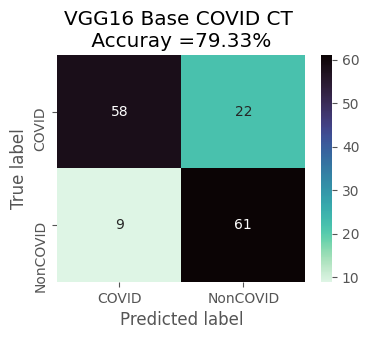

[[58 22]
 [ 9 61]]


In [46]:
## Confusion Matrix for better performance Visualization of Model
import pandas as pd
import seaborn as sns
cm = confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1))
cm_df = pd.DataFrame(cm,
index = ['COVID','NonCOVID'],
columns = ['COVID','NonCOVID'])
plt.figure(figsize=(4,3),dpi=100)
sns.heatmap(cm_df, annot=True,cmap='mako_r',fmt='g')
plt.title('VGG16 Base COVID CT \n Accuray ={0:.2f}% '.format(test_score_base[1]*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(cm)

In [62]:
## Comarison DataFrame for storing model performance.
comparison=pd.DataFrame({"Model":["Train Accuracy", "Validation Accuracy", "Test Accuracy", "Precision", "Recall","F1 Score","AUC"],
            "VGG Base Model":[train_acc_base, val_accuracy_base, test_acc_base, 0.8,0.79, 0.795,AUC_base]})

In [59]:
comparison

,Model,VGG Base Model
0,Train Accuracy,0.885906
1,Validation Accuracy,0.858333
2,Test Accuracy,0.793333
3,Precision,0.800000
4,Recall,0.790000
5,F1 Score,0.795000
6,AUC,0.891071


# VGG16 Fine Tuning

In [63]:
## Instantiating VGG model without Top layers.
vgg = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [64]:
## Adding two Dense layer after Flattening with 128 and 64 neurons with relu activation.
input_shape = vgg_model.output_shape[1]
model = Sequential()
model.add(vgg_model)
model.add(Dense(128, activation='relu', input_dim=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax')) # Dense layer with 2 neurons for binary classification with Softmax activation.
learning_rate = 0.0001 
opt = RMSprop(learning_rate=learning_rate) # RMSprop optimizer yielded better results as compared to Adam
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 25088)             14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 17,934,466
Trainable params: 3,219,778
Non-trainable params: 14,714,688
_________________________________________________________________


In [65]:
## Creating custom call backs with patience =20 and saving the best weights of model training and keeping it same for comparison purpose.
custom_callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model-1.h5', save_best_only=True,verbose=1)
]

In [66]:
## Model fit with validation split of 20% of the train data . batch_size =20 generated better results.
history1 = model.fit(X_train,y_train,validation_split=0.2,epochs=100,batch_size=20,verbose=1,callbacks=custom_callbacks)

Epoch 1/100
24/24 [==============================] - 13s 522ms/step - loss: 0.6450 - accuracy: 0.6513 - val_loss: 0.5346 - val_accuracy: 0.7167

Epoch 00001: val_loss improved from inf to 0.53459, saving model to vgg16_model-1.h5
Epoch 2/100
24/24 [==============================] - 7s 273ms/step - loss: 0.4928 - accuracy: 0.7689 - val_loss: 0.6045 - val_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.53459
Epoch 3/100
24/24 [==============================] - 7s 276ms/step - loss: 0.3694 - accuracy: 0.8361 - val_loss: 0.5463 - val_accuracy: 0.6500

Epoch 00003: val_loss did not improve from 0.53459
Epoch 4/100
24/24 [==============================] - 7s 275ms/step - loss: 0.3366 - accuracy: 0.8529 - val_loss: 0.3779 - val_accuracy: 0.8250

Epoch 00004: val_loss improved from 0.53459 to 0.37790, saving model to vgg16_model-1.h5
Epoch 5/100
24/24 [==============================] - 7s 275ms/step - loss: 0.2605 - accuracy: 0.9076 - val_loss: 0.8507 - val_accuracy: 0.6000

Epo

In [67]:
## Creating the DataFrame for trained model training history
history_df = pd.DataFrame.from_dict(history1.history)

In [68]:
history_df['epoch'] = range(1,history_df.shape[0]+1)

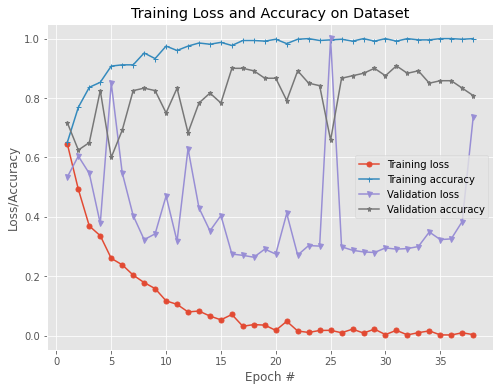

In [69]:
## Visualizing the Training Loss / Accuracy and Validation Loss/Accuracy
plt.style.use("ggplot")
fig,ax = plt.subplots()
ax.figure.set_size_inches([8,6])
ax.plot(history_df['epoch'],history_df['loss'],label='Training loss',marker='o',ms=5)
ax.plot(history_df['epoch'],history_df['accuracy'],label='Training accuracy',marker='+',ms=5)
ax.plot(history_df['epoch'],history_df['val_loss'],label='Validation loss',marker='v',ms=5)
ax.plot(history_df['epoch'],history_df['val_accuracy'],label='Validation accuracy',marker='*',ms=5)

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [78]:
# Evaluate the model w.r.t Train Loss and Train Accuracy
train_score_vgg16 = model.evaluate(X_train, y_train, verbose=1)

print('Train Loss:{:.3f}'.format(train_score_vgg16[0]))

print('Train accuracy:{:.3f}'.format(train_score_vgg16[1]))
train_acc_fine = train_score_vgg16[1]

19/19 [==============================] - 5s 244ms/step - loss: 0.0667 - accuracy: 0.9765
Train Loss:0.067
Train accuracy:0.977


In [71]:
# Evaluate the model w.r.t Test Loss and Test Accuracy
test_score_vgg16 = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:{:.3f}'.format(test_score_vgg16[0]))

print('Test accuracy:{:.3f}'.format(test_score_vgg16[1]))
test_acc_fine = test_score_vgg16[1]

5/5 [==============================] - 1s 236ms/step - loss: 0.2691 - accuracy: 0.9200
Test Loss:0.269
Test accuracy:0.920


In [72]:
## Fine Tune Model predictions on Test dataset
y_pred = model.predict(X_test)

In [73]:
## Generating Classification Report based on model predictions on fine tune model
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,recall_score
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1),target_names=names))

              precision    recall  f1-score   support

       COVID       0.91      0.94      0.93        80
    NonCOVID       0.93      0.90      0.91        70

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



In [74]:
## Area under the Curve
AUC_vgg16 = roc_auc_score(y_test,y_pred)
print("Area Under the Curve is {:.3f}".format(AUC_vgg16))

Area Under the Curve is 0.956


In [75]:
## Maximum Validation accuracy on Model Training
val_accuracy_vgg16 = np.max(history.history['val_accuracy'])
print('Val accuracy:{:.3f}'.format(val_accuracy_vgg16))

Val accuracy:0.858


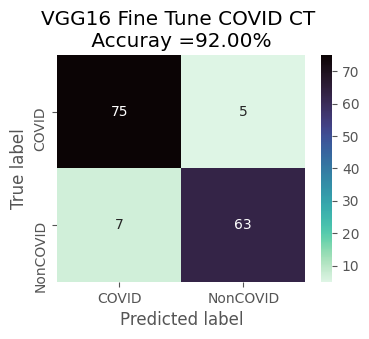

[[75  5]
 [ 7 63]]


In [76]:
## Confusion Matrix for better performance visualization of fine tune Model.
import pandas as pd
import seaborn as sns
cm = confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1))
cm_df = pd.DataFrame(cm,
index = ['COVID','NonCOVID'],
columns = ['COVID','NonCOVID'])
plt.figure(figsize=(4,3),dpi=100)
sns.heatmap(cm_df, annot=True,cmap='mako_r',fmt='g')
plt.title('VGG16 Fine Tune COVID CT \n Accuray ={0:.2f}% '.format(test_score_vgg16[1]*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(cm)

In [79]:
# Populating fine tune model values in comparison DataFrame
## Note here Precision , recall and F1 score is Avg Value.
comparison['VGG Fine Model'] = [train_acc_fine, val_accuracy_vgg16, test_acc_fine, 0.92,0.92,0.92,AUC_vgg16]

In [80]:
comparison

,Model,VGG Base Model,VGG Fine Model
0,Train Accuracy,0.885906,0.976510
1,Validation Accuracy,0.858333,0.858333
2,Test Accuracy,0.793333,0.920000
3,Precision,0.800000,0.920000
4,Recall,0.790000,0.920000
5,F1 Score,0.795000,0.920000
6,AUC,0.891071,0.956429
